In [60]:
import itertools

import graph_tool.all as gt

import joblib
import numpy as np
import scipy as sp
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import *

%matplotlib inline
%autosave 15

Autosaving every 15 seconds


Приведём реализацию предложенного 2-оптимального алгоритма, используя примитивы из ```graph-tool```:

In [89]:
%%time
def powerset(iterable):
    """
    Returns an iterator over subsets of iterable.
    """
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))


def steiner_tree_2_opt(G, V0):
    """
    Given weighted undirected graph, finds an approximation to the Steiner tree
    that has at least two times larger cost than the actual tree.
    
    @param G — graph_tool.Graph. Must have an edge-property "w" — the edge weights.
    @param V0 — np.array, a subset of indices corresponding to the terminal vertices.
    @return (np.float32, np.array), the cost and the tree
    """
    n = G.num_vertices()
    # Calculate shortest distances using Floyd's algorithm
    sd_pm = gt.shortest_distance(G, weights=G.ep["w"], 
                                 directed=False, dense=True)
    sd = np.vstack([sd_pm[v] for v in G.vertices()])
    # Construct the metric closure
    K_n = gt.complete_graph(n, directed=False)
    K_n.ep["w"] = K_n.new_edge_property("double")
    indices = np.triu_indices_from(sd, k=1) # https://vk.cc/8D03ZI
    K_n.ep["w"].a = np.asarray(sd[indices])
    # Subselect the subgraph induced by the terminal nodes
    V0_vfilt = K_n.new_vertex_property("bool")
    V0_vfilt.a[V0] = True
    K_V0 = gt.GraphView(K_n, vfilt=V0_vfilt.a)
    # Find the MST in that induced subgraph
    MST = gt.min_spanning_tree(K_V0, weights=K_n.ep["w"])
    mst_cost = np.sum(K_n.ep["w"].a[MST.a == 1])
    return mst_cost, MST.a


def steiner_tree(G, V0):
    # Как тут получить argmin? Причём хотелось бы не за экспоненту памяти...
    """
    Given weighted undirected graph, finds an actual Steiner tree in exponential time
    
    @param G — graph_tool.Graph. Must have an edge-property "w" — the edge weights.
    @param V0 — np.array, a subset of indices corresponding to the terminal vertices.
    @return (np.float32, np.array), the cost and the tree
    """
    def process_mask(subset):
        """
        Implementation of the main logic that gets plugged into joblib.Parallel.
        Subselects the subgraph induced by the terminal nodes and some other 
        nodes specified in "subset", finds MST in it and returns its cost.
        """
        mask = np.full(G.num_vertices(), False)
        mask[V0] = True
        if len(subset) > 0:
            mask[np.array(subset)] = True
        H = gt.GraphView(G, vfilt=mask)
        conn = gt.label_largest_component(H)
        if np.sum(conn.a) != np.sum(mask):
            return np.inf # not connected
        H_MST = gt.min_spanning_tree(H, weights=H.ep["w"])
        h_mst_cost = np.sum(H.ep["w"].a[H_MST.a == 1])
        return h_mst_cost
    # перебор подмножеств легко распараллеливается
    # все итерации цикла независимы друг от друга
    st_cost = np.asscalar(np.min(joblib.Parallel(n_jobs=4)(
        joblib.delayed(process_mask)(s)
        for s in tqdm_notebook(powerset(np.setdiff1d(np.arange(n), V0)))
    )))
    return st_cost
    
    
cost_2_opt, mask_2_opt = steiner_tree_2_opt(G, V0)
cost_opt = steiner_tree(G, V0)
print(cost_2_opt, cost_opt, cost_2_opt / cost_opt)

35.35958810514174 35.35958810514174 1.0
CPU times: user 135 ms, sys: 12 ms, total: 147 ms
Wall time: 2.93 s


Сгенерируем случайные графы в модели Эрдёша-Реньи (ну, почти; в graph-tool ничего более похожего сделать не удалось):

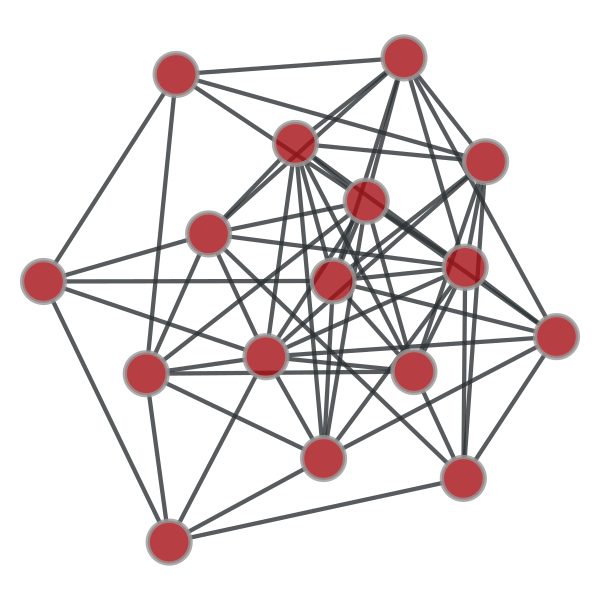

[ 0 13  8 15]


In [85]:
n, k, p = 16, 4, 0.5
# G = gt.Graph(directed=False)
# w = G.new_edge_property("double")
# c = G.new_vertex_property("string")
# for i in range(n):
#     v = G.add_vertex()
#     c[v] = "blue" if i == 0 else "red"
# G.vertex_properties["fill_color"] = c
# for i in range(1, n):
#     w[G.add_edge(0, i)] = 1
#     w[G.add_edge(i, max(1, (i + 1) % n))] = 2
# gt.graph_draw(G, vertex_fill_color=c);
G = gt.random_graph(n, lambda: np.random.poisson(n * p), directed=False);
G.ep["w"] = G.new_ep("double")
G.ep["w"].a = np.random.rand(G.num_edges()) * 42
gt.graph_draw(G);
V0 = np.random.choice(np.arange(n),  k)
print(V0)